# Gender Classification and Speaker Authentication

## Preprocessing

In [ ]:
import os
import re

### Define patterns

In [ ]:
# Dataset address
folder_path = "../Data/HW1_M"

# Regex patterns for gender
gender_pattern = r"(male|female)"

# Student Id pattern
id_pattern = r"\d{9}"

### Extract the gender and student id's

In [ ]:
valid_files = {}

files = os.listdir(folder_path)

for file in files:
    if file.endswith(".mp3"):
        file_path = os.path.join(folder_path, file)

        gender_match = re.search(gender_pattern, file.lower())
        id_match = re.search(id_pattern, file)

        if gender_match and id_match:
            gender = gender_match.group(0)
            file_id = id_match.group(0)
            valid_files[file_path] = {"gender": gender, "ID": file_id}

print(valid_files)

{'../Data/HW1_M\\HW1-Q2-2-810103226-male.mp3': {'gender': 'male', 'ID': '810103226'}, '../Data/HW1_M\\HW1-Q3-810103226-male.mp3': {'gender': 'male', 'ID': '810103226'}, '../Data/HW1_M\\HW1-Q4-1-810103226-male.mp3': {'gender': 'male', 'ID': '810103226'}, '../Data/HW1_M\\HW1-Q4-3-810103226-male.mp3': {'gender': 'male', 'ID': '810103226'}, '../Data/HW1_M\\HW1-Q6-810801075-male.mp3': {'gender': 'male', 'ID': '810801075'}, '../Data/HW1_M\\HW1.Q2b.810102087_female.mp3': {'gender': 'female', 'ID': '810102087'}, '../Data/HW1_M\\HW1.Q4c.810102087_female.mp3': {'gender': 'female', 'ID': '810102087'}, '../Data/HW1_M\\HW1.Q4j.810102087_female.mp3': {'gender': 'female', 'ID': '810102087'}, '../Data/HW1_M\\HW1_into_810103317_male.mp3': {'gender': 'male', 'ID': '810103317'}, '../Data/HW1_M\\HW1_intro_610300070_female.mp3': {'gender': 'female', 'ID': '610300070'}, '../Data/HW1_M\\HW1_intro_610399205_male.mp3': {'gender': 'male', 'ID': '610399205'}, '../Data/HW1_M\\HW1_intro_610399206_male.mp3': {'gend

### Denoising

In [ ]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

Analyze the signal characteristics of audio files to estimate noise.

In [ ]:
def analyze_signal_noise(file_data, target_rate, num_samples=500):
    snr_values = []
    sample_files = list(file_data.keys())[:num_samples]

    for idx, file_path in enumerate(sample_files):
        try:
            audio, sr = librosa.load(file_path, sr=target_rate)

            # Estimate Signal-to-Noise Ratio (SNR)
            rms_signal = np.sqrt(np.mean(audio ** 2))
            noise_threshold = 0.1 * np.max(audio)  # threshold for noise detection
            noise_samples = audio[audio < noise_threshold]
            rms_noise = np.sqrt(np.mean(noise_samples ** 2)) if len(noise_samples) > 0 else 0

            snr = 10 * np.log10(rms_signal / rms_noise) if rms_noise > 0 else float('inf')
            snr_values.append(snr)

            if idx < 2:
                # waveform
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.plot(audio)
                plt.title(f"Waveform")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")

                # spectrogram
                D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
                plt.subplot(1, 2, 2)
                librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
                plt.title(f"Spectrogram")
                plt.colorbar(format="%+2.0f dB")
                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    plt.figure(figsize=(10, 6))
    plt.hist(snr_values, bins=20, color='lightblue', edgecolor='black')
    plt.title("Distribution of Signal-to-Noise Ratios (SNR)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    mean_snr = np.mean(snr_values) if snr_values else 0
    print(f"Mean SNR of sample files: {mean_snr:.2f} dB")

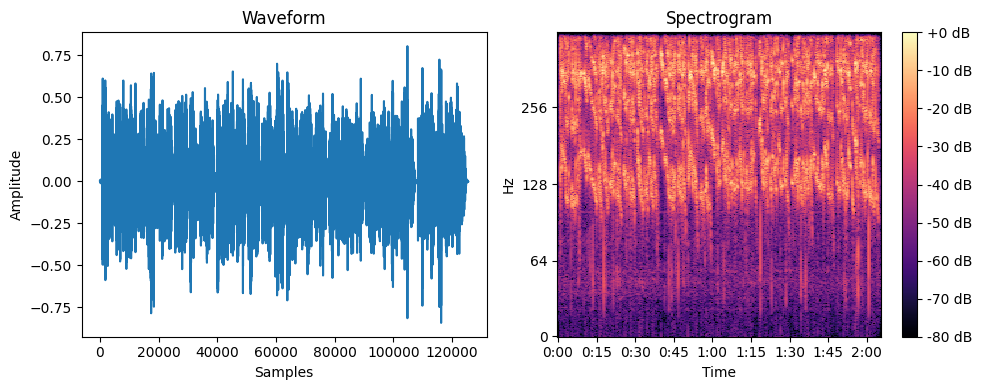

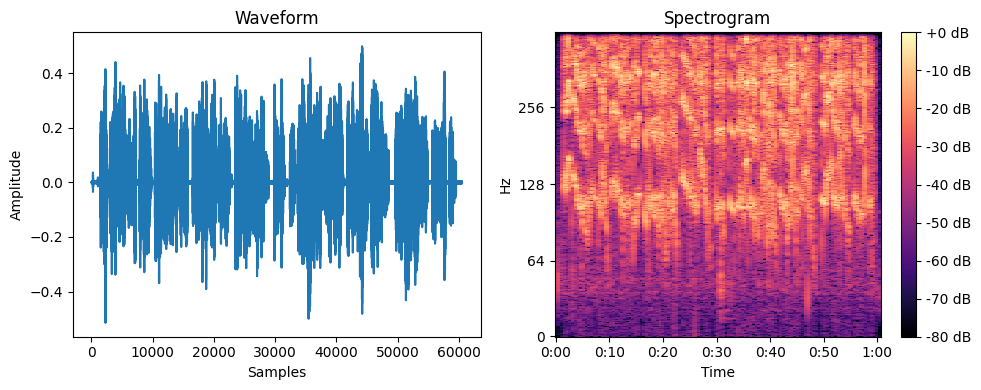

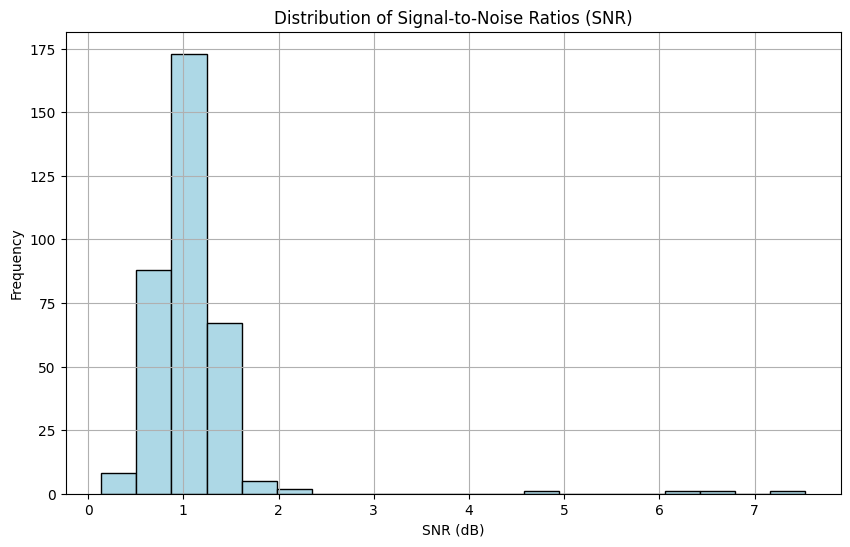

Mean SNR of sample files: 1.09 dB


In [ ]:
target_sampling_rate = 1000
analyze_signal_noise(valid_files, target_sampling_rate)

#### Bandpass Filter

In [ ]:
from scipy.signal import butter, filtfilt
import soundfile as sf

Bandpass filter to remove frequencies outside speech range.

In [ ]:
def bandpass_filter(audio, lowcut=100.0, highcut=8000.0, fs=1000.0, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, audio)

#### Spectral Subtraction

Apply spectral subtraction to remove noise.

In [ ]:
def spectral_subtraction(audio, sr, noise_estimation_window=1.0, noise_fraction=0.2):
    # short-time Fourier transform (STFT)
    D = librosa.stft(audio)
    magnitude, phase = librosa.magphase(D)

    # Estimate the noise
    noise_estimation_samples = int(noise_estimation_window * sr)
    noise_magnitude = np.mean(magnitude[:, :noise_estimation_samples], axis=1)

    # subtract the noise estimate from the magnitude spectrum
    magnitude_denoised = magnitude - noise_fraction * noise_magnitude[:, np.newaxis]
    magnitude_denoised = np.maximum(magnitude_denoised, 0)

    # Reconstruct the signal
    D_denoised = magnitude_denoised * phase
    audio_denoised = librosa.istft(D_denoised)

    return audio_denoised

Apply bandpass filter and spectral subtraction, then save.

In [ ]:
def process_and_save_files(file_data, output_dir="../Data/Denoized"):
    os.makedirs(output_dir)
    sample_no = 1

    for file_path, metadata in file_data.items():
        try:
            audio, sr = librosa.load(file_path, sr=None)

            # Apply bandpass filter
            try:
                filtered_audio = bandpass_filter(audio, lowcut=100.0, highcut=8000.0, fs=sr, order=5)
            except ValueError as e:
                print(f"Skipping {file_path} due to error: {e}")
                continue

            # Apply spectral subtraction
            denoised_audio = spectral_subtraction(filtered_audio, sr)

            file_name = f"{metadata['ID']}-{metadata['gender']}-{sample_no}.wav"
            output_path = os.path.join(output_dir, file_name)

            sf.write(output_path, denoised_audio, sr)
            sample_no += 1

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

In [ ]:
process_and_save_files(valid_files)

Skipping ../Data/HW1_M\HW1_intro_810103092_male.mp3 due to error: Digital filter critical frequencies must be 0 < Wn < 1
Skipping ../Data/HW1_M\HW1_Q1_a_810103092_male.mp3 due to error: Digital filter critical frequencies must be 0 < Wn < 1
Skipping ../Data/HW1_M\HW1_Q1_b_810103092_male.mp3 due to error: Digital filter critical frequencies must be 0 < Wn < 1
Skipping ../Data/HW1_M\HW1_Q2_a_810103092_male.mp3 due to error: Digital filter critical frequencies must be 0 < Wn < 1
Skipping ../Data/HW1_M\HW1_Q6_810103092_male.mp3 due to error: Digital filter critical frequencies must be 0 < Wn < 1


### Sampling rate

Analyze and visualize the sampling rate so that we can decide about the resampling.

In [ ]:
def analyze_sampling_rates_from_dict(folder_path):
    sampling_rates = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mp3') or file.endswith('.wav'):
                file_path = os.path.join(root, file)
                try:
                    # Load the audio file with the original sampling rate
                    _, sr = librosa.load(file_path, sr=None)
                    sampling_rates.append(sr)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    unique_rates = set(sampling_rates)
    mean_rate = sum(sampling_rates) / len(sampling_rates) if sampling_rates else 0

    plt.figure(figsize=(10, 6))
    plt.hist(sampling_rates, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Sampling Rates")
    plt.xlabel("Sampling Rate (Hz)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return {
        "unique_rates": unique_rates,
        "mean_rate": mean_rate
    }

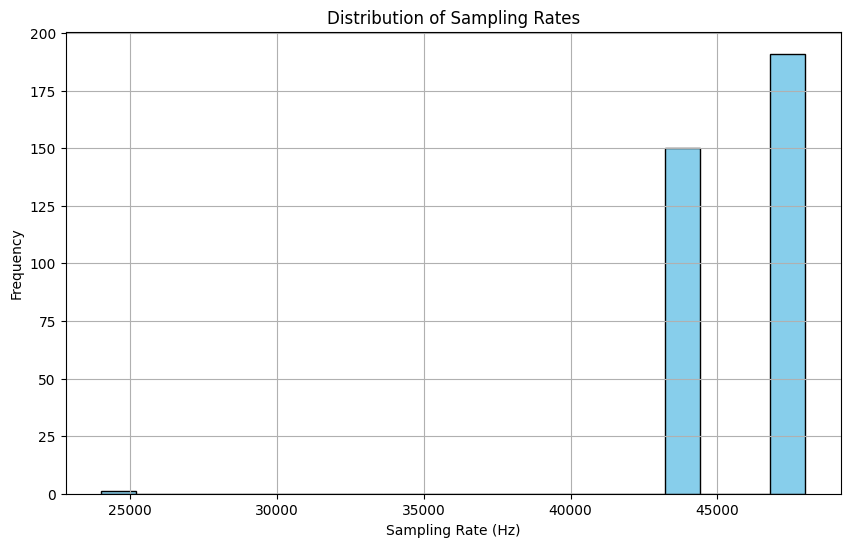

Unique Sampling Rates: {48000, 44100, 24000}
Mean Sampling Rate: 46219.29824561404


In [ ]:
results = analyze_sampling_rates_from_dict("../Data/Denoized")
print("Unique Sampling Rates:", results["unique_rates"])
print("Mean Sampling Rate:", results["mean_rate"])

### Resampling

Resample audio files to a target sampling rate and save them in a new directory.

In [ ]:
def resample_and_save(folder_path, output_dir, target_rate=1000):

    os.makedirs(output_dir, exist_ok=True)
    sample_no = 1

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mp3') or file.endswith('.wav'):
                file_path = os.path.join(root, file)

                try:
                    audio, sr = librosa.load(file_path, sr=None)

                    # Resample to the target rate
                    resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=target_rate)

                    new_file_path = os.path.join(output_dir, file)

                    sf.write(new_file_path, resampled_audio, samplerate=target_rate)
                    sample_no += 1

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

In [ ]:
output_directory = "../Data/resampled"
target_sampling_rate = 1000
resample_and_save("../Data/Denoized", output_directory, target_sampling_rate)

### Split and divide to shorter samples

Analyze the length of resampled audio files and plot the distribution.

In [ ]:
def analyze_audio_lengths(folder_path, target_rate=1000):
    lengths = []
    file_paths = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mp3') or file.endswith('.wav'):
                file_path = os.path.join(root, file)

                try:
                    audio, sr = librosa.load(file_path, sr=target_rate)

                    # the length of the audio in seconds
                    length_in_seconds = len(audio) / target_rate
                    lengths.append(length_in_seconds)
                    file_paths.append(file_path)

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    mean_length = sum(lengths) / len(lengths) if lengths else 0
    min_lenght = min(lengths)

    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, color='lightcoral', edgecolor='black')
    plt.title("Distribution of Audio Lengths")
    plt.xlabel("Length (seconds)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return {
        "mean_length": mean_length,
        "lengths": lengths,
        "min_length": min_lenght
    }

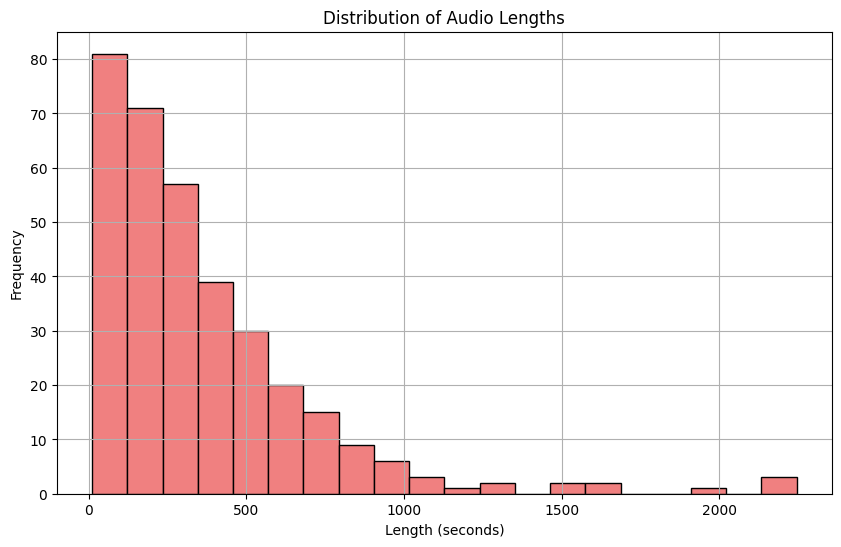

Mean Length of Audio Files: 360.80800877192996
Mininum lenght of Audio Files: 10.867


In [ ]:
target_sampling_rate = 1000
results = analyze_audio_lengths("../Data/Denoized", target_sampling_rate)
print("Mean Length of Audio Files:", results["mean_length"])
print("Mininum lenght of Audio Files:", results["min_length"])

In [ ]:
def normalize_audio(audio):
    # Normalize the audio to have values between -1 and 1.
    return audio / np.max(np.abs(audio)) if np.max(np.abs(audio)) != 0 else audio

In [ ]:
def split_audio_samples(folder_path, output_dir, segment_length=10, target_rate=1000):

    os.makedirs(output_dir, exist_ok=True)

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.mp3') or file.endswith('.wav'):
                file_path = os.path.join(root, file)

                try:
                    audio, sr = librosa.load(file_path, sr=target_rate)

                    segment_samples = segment_length * target_rate
                    num_segments = int(np.floor(len(audio) / segment_samples))

                    # Split the audio
                    for i in range(num_segments):
                        start_sample = i * segment_samples
                        end_sample = (i + 1) * segment_samples
                        segment_audio = audio[start_sample:end_sample]

                        # Normalize the sample
                        segment_audio = normalize_audio(segment_audio)

                        student_id = file.split('-')[0]
                        gender = file.split('-')[1].lower()
                        new_file_name = f"{student_id}-{gender}-{i+1}.wav"
                        new_file_path = os.path.join(output_dir, new_file_name)

                        sf.write(new_file_path, segment_audio, samplerate=target_rate)

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

In [ ]:
folder_path = "../Data/resampled"
output_dir = "../Data/Samples"
split_audio_samples(folder_path, output_dir)

## Feature Extraction

In [ ]:
def feature_extract(audio_path):
  y, sr = librosa.load(audio_path, sr=None)

  # 1. MFCC
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

  # 2. Log Mel Spectrogram
  mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

  # 3. Energy
  energy = np.sum(y**2) / len(y)

  # Combine features
  combined_features = np.vstack([mfccs, log_mel_spectrogram])
  return combined_features, energy

In [ ]:
features = np.array([])
dir = '/content/drive/My Drive/ML_Final/Data/Samples'
for filename in os.listdir(dir)
  file_path = os.path.join(dir, filename)
  if os.path.isfile(file_path):
    combined_features, energy = feature_extract(file_path)
    combined_features = np.append(combined_features.flatten(), energy)
    if features.size != 0:
      features = np.vstack([features, combined_features])
    else:
      features = np.array([combined_features])
print("Combined Features Dataset Shape:", features.shape)

Combined Features Dataset Shape: (6147, 2821)


In [ ]:
#Extract 3 PCs
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)
pca = PCA(n_components=3)
PC_features = pca.fit_transform(df_scaled)

<ipython-input-13-cdab69d40d38>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(PC_features[:, 0], PC_features[:, 1], PC_features[:, 2], cmap='viridis', marker='o')


Text(0.5, 0.92, '3D Sound Plot')

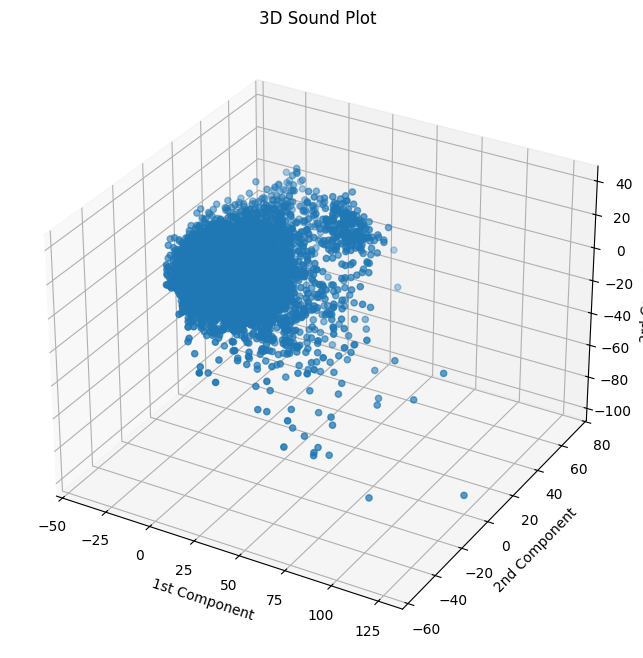

In [ ]:
#3D Plot of PCs of Sounds
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC_features[:, 0], PC_features[:, 1], PC_features[:, 2], cmap='viridis', marker='o')
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.set_zlabel("3rd Component")
ax.set_title("3D Sound Plot")

In [ ]:
#Proper Number of PComponents
pca = PCA()
pca.fit(df_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
#Best Number of PComponents
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print('Number of Components to Preserve 95% of Variance:', n_components_95)

Number of Components to Preserve 95% of Variance: 219


In [ ]:
#Transform Data to its PCs
pca_optimal = PCA(n_components=n_components_95)
transformed_data = pca_optimal.fit_transform(df_scaled)
print("Shape of Transformed Data:", transformed_data.shape)

Shape of Transformed Data: (6147, 219)


In [ ]:
#Convert to DF and Add ID and Gender Data
df_pca = pd.DataFrame(transformed_data, columns=[f"PC{i+1}" for i in range(n_components_95)])
ids = []
genders = []
for filename in os.listdir(dir):
  ids.append(filename.split('-')[0])
  genders.append(1 if filename.split('-')[1] == 'male' else 0)
df_pca['ID'] = ids
df_pca['Gender'] = genders

# Clustering

## Sequential Clustering

In [ ]:
#Sequential Clustering
def sequential_clustering(threshold, data: pd.DataFrame):
    """
    treshhold: treshhold to make a new cluster
    data: data to cluster
    """
    clusters = []
    means = []
    labels = []

    for row in data.values:
        row = np.array(row, dtype=np.float64)  # Ensure it's a NumPy array with float type
        added = False
        min_dis = float('inf')
        min_i = -1

        for i in range(len(clusters)):
            distance = np.linalg.norm(row - means[i])
            if distance < threshold and distance < min_dis:
                added = True
                min_dis = distance
                min_i = i

        if not added:
            labels.append(len(means))
            clusters.append(np.array([row]))
            means.append(row)
        else:
            # Update mean correctly using the formula:
            # new_mean = (old_mean * cluster_size + new_point) / (cluster_size + 1)
            cluster_size = clusters[min_i].shape[0]
            means[min_i] = (means[min_i] * cluster_size + row) / (cluster_size + 1)

            # Add new row to cluster
            clusters[min_i] = np.vstack([clusters[min_i], row])
            labels.append(min_i)

    return labels


## Kmeans

In [ ]:
def k_means(k, data: pd.DataFrame):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    return labels

In [ ]:
#Explore the Best Parameter for Sequential Clustering
df_pca.sort_values('ID', inplace = True)
max_score = 0
best_tresh = 0
scores_seq = []
for treshhold in range(30, 150, 5):
  labels = sequential_clustering(treshhold, df_pca.iloc[:, :-2])
  sil_score = silhouette_score(df_pca.iloc[:, :-2], labels)
  scores_seq.append(sil_score)
  if sil_score > max_score:
    best_tresh = treshhold
    max_score = sil_score

print('Best Treshhold for the Sequential Clustering:', best_tresh)

Best Treshhold for the Sequential Clustering: 145


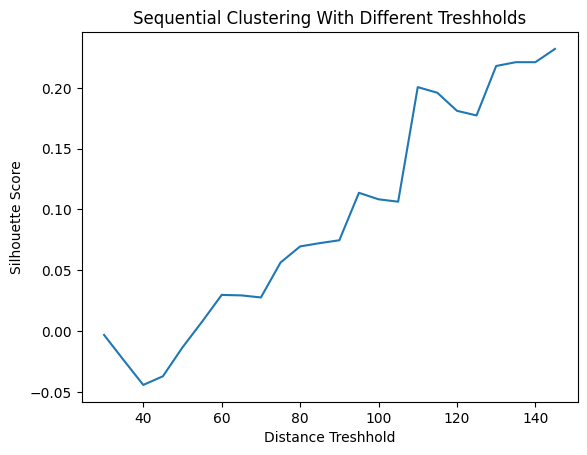

In [ ]:
plt.plot([5 * i + 30 for i in range(len(scores_seq))], scores_seq)
plt.xlabel('Distance Treshhold')
plt.ylabel('Silhouette Score')
plt.title('Sequential Clustering With Different Treshholds')
plt.show()

In [ ]:
#Explore the Best Parameter for Kmeans
max_score = 0
best_k = 0
scores_kmean = []
for k in range(2, 116, 5):
  labels = k_means(k, df_pca.iloc[:, :-2])
  sil_score = silhouette_score(df_pca.iloc[:, :-2], labels)
  scores_kmean.append(sil_score)
  if sil_score > max_score:
    best_k = k
    max_score = sil_score

print('Best K for the Kmeans:', best_k)

Best K for the Kmeans: 2


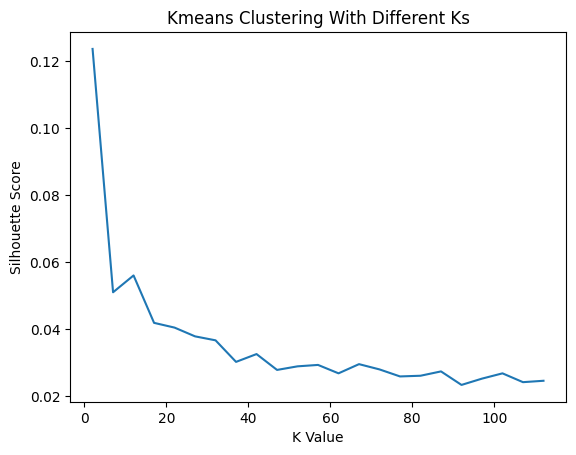

In [ ]:
plt.plot([5 * i + 2 for i in range(len(scores_kmean))], scores_kmean)
plt.xlabel('K Value')
plt.ylabel('Silhouette Score')
plt.title('Kmeans Clustering With Different Ks')
plt.show()

In [ ]:
labels_seq = sequential_clustering(best_tresh, df_pca.iloc[:, :-2])

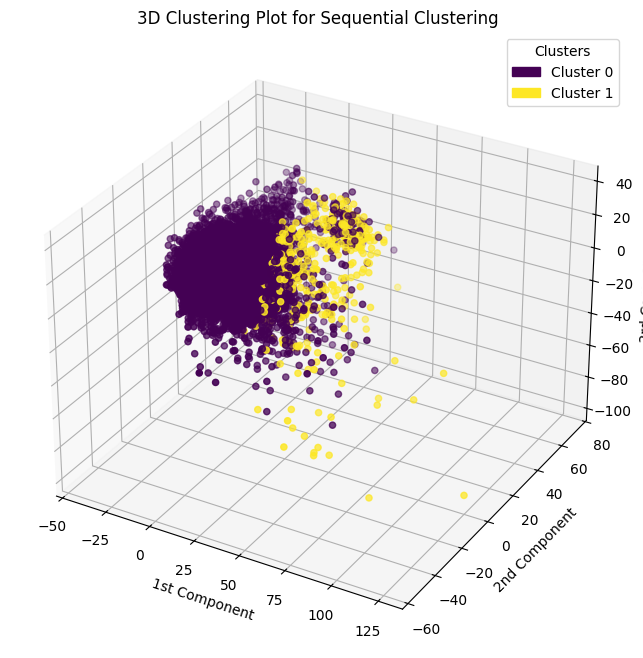

In [ ]:
unique_labels = np.unique(labels_seq)  # Get unique cluster labels
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

# Create a figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping
sc = ax.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], df_pca.iloc[:, 2],
                c=labels_seq, cmap='viridis', marker='o')

# Create legend manually
legend_handles = [mpatches.Patch(color=colors[i], label=f"Cluster {unique_labels[i]}") for i in range(len(unique_labels))]
ax.legend(handles=legend_handles, title="Clusters", loc="upper right")

# Labels & title
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.set_zlabel("3rd Component")
ax.set_title("3D Clustering Plot for Sequential Clustering")

plt.show()

In [ ]:
labels_kmeans = k_means(best_k, df_pca.iloc[:, :-2])

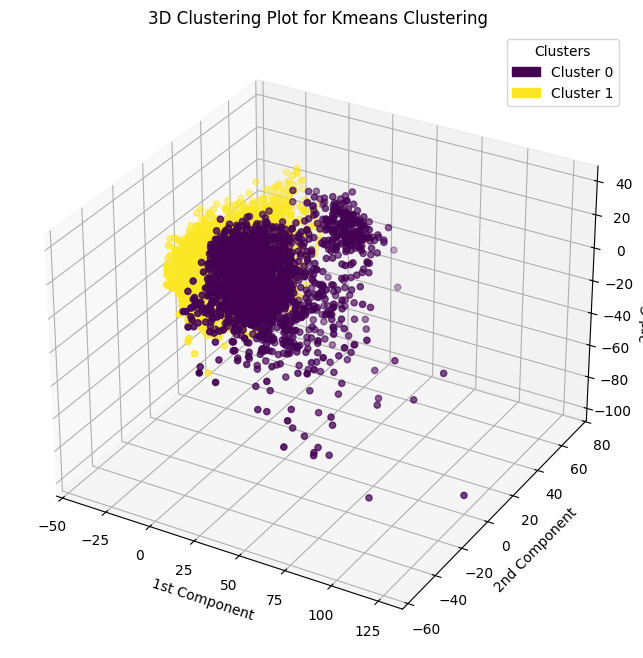

In [ ]:
unique_labels = np.unique(labels_kmeans)  # Get unique cluster labels
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Generate colors

# Create a figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color mapping
sc = ax.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], df_pca.iloc[:, 2],
                c=labels_kmeans, cmap='viridis', marker='o')

# Create legend manually
legend_handles = [mpatches.Patch(color=colors[i], label=f"Cluster {unique_labels[i]}") for i in range(len(unique_labels))]
ax.legend(handles=legend_handles, title="Clusters", loc="upper right")

# Labels & title
ax.set_xlabel("1st Component")
ax.set_ylabel("2nd Component")
ax.set_zlabel("3rd Component")
ax.set_title("3D Clustering Plot for Kmeans Clustering")

plt.show()

In [ ]:
#Explore Kmeans
pca_clusters = df_pca.loc[:, ['ID', 'Gender']]
pca_clusters['kmeans'] = labels_kmeans
pca_clusters['seq'] = labels_seq
percentages = (
    pca_clusters.groupby(['Gender', 'kmeans'])['ID']
    .count()
    .groupby(level=0)  # Normalize within each 'Gender' group
    .apply(lambda x: 100 * x / x.sum())
)

display(percentages)
print('How Gender is Distributed in to Clusters Kmeans')

Gender  Gender  kmeans
0       0       0         94.282084
                1          5.717916
1       1       0         13.535972
                1         86.464028
Name: ID, dtype: float64

How Gender is Distributed in to Clusters Kmeans


In [ ]:
# Exlore Seq_Clustering
percentages = (
    pca_clusters.groupby(['Gender', 'seq'])['ID']
    .count()
    .groupby(level=0)  # Normalize within each 'Gender' group
    .apply(lambda x: 100 * x / x.sum())
)

display(percentages)
print('How Gender is Distributed in to Clusters Seq Clustering')

Gender  Gender  seq
0       0       0      86.594663
                1      13.405337
1       1       0      96.632408
                1       3.367592
Name: ID, dtype: float64

How Gender is Distributed in to Clusters Seq Clustering


In [ ]:
dist = (
    pca_clusters.groupby(['ID'])['seq']
    .apply(lambda x: max(100 * x.sum() / len(x), 100 * (1-(x.sum()) / len(x))))
)
display(dist)
print('What is Percent of Existance of Each Person in Each Class Sequential Learning')

,seq
ID,
151501033,100.000000
159403005,99.553571
610300017,100.000000
610300032,100.000000
610300070,100.000000
...,...
810600133,91.111111
810800024,87.500000
810801072,97.500000


What is Percent of Existance of Each Person in Each Class Sequential Learning


In [ ]:
counter = (
    pca_clusters.groupby(['ID'])['seq']
    .count()
)
print('Average Percent of Existance of Each Individual in Each Class:',(counter * dist).sum() / counter.sum())

Average Percent of Existance of Each Individual in Each Class: 94.9406214413535


In [ ]:
counter = (
    pca_clusters.groupby(['ID'])['seq']
    .apply(lambda x: (1-x).sum() / len(x))
)
print("People whose voices' maximium cluster is not 0:", counter[counter < 0.5].index)

People whose voices' maximium cluster is not 0: Index([810199489], dtype='int64', name='ID')


In [ ]:
# Kmeans for IDs
print('Number of Individuals:', df_pca.ID.unique().shape[0])
labels_kmeans = k_means(df_pca.ID.unique().shape[0], df_pca.iloc[:, :-3])

Number of Individuals: 113


In [ ]:
pca_clusters['kmeans'] = labels_kmeans
dist = (
    pca_clusters.groupby(['ID', 'kmeans'])['Gender']
    .count()
)
display(dist)
print('What is Percent of Existance of Each Person in Each Class Kmeans Learning')

ID         kmeans
151501033  13         2
           18        10
           21         1
           26         1
           29         1
                     ..
810899073  56         1
           61         1
           73         2
           78         1
           100        1
Name: Gender, Length: 1435, dtype: int64

What is Percent of Existance of Each Person in Each Class Kmeans Learning


In [ ]:
new_pca = df_pca
new_pca['kmeans'] = pca_clusters['kmeans']
id_1_group_1 = new_pca[(new_pca['kmeans'] == 21)].iloc[0, :-3]
id_2_group_2 = new_pca[(new_pca['kmeans'] == 21)].iloc[1, :-3]
id_1_group_2 = new_pca[(new_pca['kmeans'] == 26)].iloc[0, :-3]
print('First Vector: ID', new_pca[(new_pca['kmeans'] == 21)].iloc[0, -3], 'Sample From Cluster', new_pca[(new_pca['kmeans'] == 21)].iloc[0, -1])
print('Second Vector: ID', new_pca[(new_pca['kmeans'] == 21)].iloc[1, -3], 'Sample From Cluster', new_pca[(new_pca['kmeans'] == 21)].iloc[1, -1])
print('Third Vector: ID', new_pca[(new_pca['kmeans'] == 26)].iloc[0, -3], 'Sample From Cluster', new_pca[(new_pca['kmeans'] == 26)].iloc[0, -1])
print('Distance of Vector One and Three:', np.linalg.norm(id_1_group_1 - id_1_group_2))
print('Distance of Vector Three and Two:', np.linalg.norm(id_1_group_2 - id_2_group_2))

First Vector: ID 151501033 Sample From Cluster 21
Second Vector: ID 810100130 Sample From Cluster 21
Third Vector: ID 151501033 Sample From Cluster 26
Distance of Vector One and Three: 66.84590220095198
Distance of Vector Three and Two: 66.55363880373801


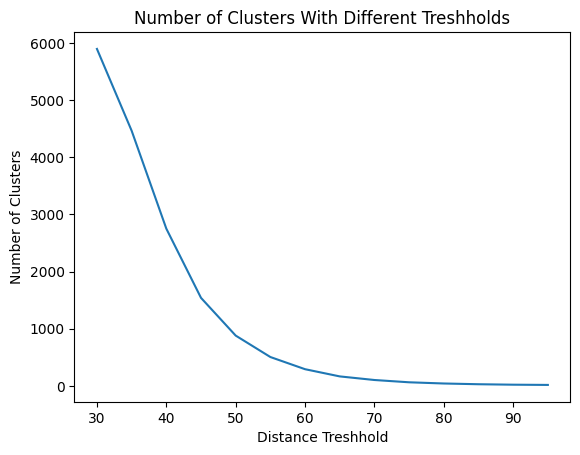

In [ ]:
#Explore Seq_Cluster with Other Treshholds (Classes Equal to Number of Students)
count_labels = []
#Explore number of clusters corresponding to number distance treshhold
for i in range(30, 100, 5):
  labels = sequential_clustering(i, df_pca.iloc[:, :-2])
  count_labels.append(len(np.unique(labels)))
plt.plot([5 * i + 30 for i in range(len(count_labels))], count_labels)
plt.xlabel('Distance Treshhold')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters With Different Treshholds')
plt.show()


In [ ]:
dist_best = 5 * (np.argmin(np.abs(np.array(count_labels) - df_pca.ID.unique().shape[0]))) + 30
labels = sequential_clustering(dist_best, df_pca.iloc[:, :-2])
print("Distance which Leads to 113 Number of Clusters:", dist_best)

Distance which Leads to 113 Number of Clusters: 70


In [ ]:
pca_clusters['seq'] = labels
dist = (
    pca_clusters.groupby(['ID', 'seq'])['Gender']
    .count()
)
display(dist)
print('What is Percent of Existance of Each Person in Each Class Sequential Learning')

ID         seq
151501033  0      48
           1       1
           2       1
           3       2
           4       1
                  ..
810801075  32      1
           33      1
810899073  0      13
           28      1
           102     1
Name: Gender, Length: 671, dtype: int64

What is Percent of Existance of Each Person in Each Class Sequential Learning


## Classification

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Set numpy seed

In [ ]:
np.random.seed(343)

In [ ]:
data = pd.read_csv("../Data/features_pca.csv")
data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,ID,Gender
0,1.019553,-3.938055,4.794981,8.388686,6.993591,16.154174,4.168664,8.570469,17.819767,10.544898,...,0.698704,-0.649466,1.187164,-0.823548,-0.047505,-0.447572,0.187228,0.084856,810198500,1
1,-20.739068,29.617497,14.639368,6.020254,3.495696,1.480552,-2.665145,-2.107677,1.247998,0.785667,...,0.501977,1.167683,-0.723508,-0.761981,-0.088961,0.722321,0.767445,-0.131593,810199328,1
2,-18.173695,1.979864,1.177314,0.801710,-16.811249,-3.765919,-4.940953,4.773938,-5.813769,-2.244340,...,-0.093563,-0.083585,0.033283,0.805421,0.916937,-0.912367,-1.547788,-0.575424,810103317,1
3,4.483309,26.806960,5.306354,-10.556056,5.348658,-3.567116,18.455102,-6.893732,-3.333857,-10.835616,...,-0.483147,0.210671,1.257597,0.621144,-1.151663,-0.154786,0.312031,-0.024538,810199328,1
4,-14.244577,-17.835984,-0.824356,5.340507,10.621045,-10.092610,4.323982,3.158635,9.440847,-4.750977,...,-0.621970,0.713787,-1.995366,-0.359137,0.368459,0.599139,-1.079611,0.239677,810103322,1


In [ ]:
unique_ids = data['ID'].unique()
print("There are totally", len(unique_ids), "students")

There are totally 113 students


# Gender Classification

## Data Preparation

There are totally 113 unique student IDs, so we will use 100 (50 male and 50 female) (25%) students' data for gender classification.

In [ ]:
male_ids = data[data['Gender'] == 1]['ID'].values  # Gender = 1
female_ids = data[data['Gender'] == 0]['ID'].values  # Gender = 0

selected_male = np.random.choice(male_ids, size=50, replace=False)
selected_female = np.random.choice(female_ids, size=50, replace=False)

selected_students = np.concatenate((selected_male, selected_female))
print(selected_students)

[159403005 159403005 810103106 810101420 810103019 810103106 810600125
 810103022 159403005 151501033 810101575 810102160 159403005 810103317
 159403005 810100130 810103054 159403005 810103146 810103345 159403005
 810199423 810101503 810101575 810600125 810103022 810101465 810102029
 810103019 810103262 810101419 151501033 810600125 810103222 810103008
 810101540 810100130 810199328 810101575 810103106 810101465 810100107
 810103057 810103317 810199569 810101420 810102286 810199423 810101540
 810600125 610300070 810102327 810100135 810199570 810199489 810101456
 810100590 810199489 810103197 810101456 810102027 810199489 810102148
 810101551 810100222 810199489 810100135 810199489 810102027 610300070
 810100135 810101456 810102327 810101456 610300070 810600097 810100268
 810101551 810100075 810199489 810199489 810102017 810102027 810199489
 810100590 810600065 810100193 810100075 810199570 810600088 810102027
 810101551 810101456 810199489 810100135 810100268 810199570 610300070
 61030

In [ ]:
data_gender = data[data["ID"].isin(selected_students)]
data_gender

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,ID,Gender
1,-20.739068,29.617497,14.639368,6.020254,3.495696,1.480552,-2.665145,-2.107677,1.247998,0.785667,...,0.501977,1.167683,-0.723508,-0.761981,-0.088961,0.722321,0.767445,-0.131593,810199328,1
2,-18.173695,1.979864,1.177314,0.801710,-16.811249,-3.765919,-4.940953,4.773938,-5.813769,-2.244340,...,-0.093563,-0.083585,0.033283,0.805421,0.916937,-0.912367,-1.547788,-0.575424,810103317,1
3,4.483309,26.806960,5.306354,-10.556056,5.348658,-3.567116,18.455102,-6.893732,-3.333857,-10.835616,...,-0.483147,0.210671,1.257597,0.621144,-1.151663,-0.154786,0.312031,-0.024538,810199328,1
8,-26.858334,-3.771963,7.361795,1.031939,-11.424464,-4.142013,1.957140,-0.795764,-1.366871,-5.297329,...,-1.442845,-0.482896,0.361615,-0.100872,-0.791132,-0.471812,0.184273,0.195867,810103317,1
13,8.489079,-10.829325,-22.520279,-6.502274,-7.968092,1.489209,6.667228,0.903535,3.076287,4.731035,...,0.698216,0.137821,1.908007,-0.067432,-0.135536,-0.939010,-0.846970,-0.663935,810199423,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6142,-18.079931,4.836377,1.158802,1.335362,-16.832460,13.224614,1.479850,3.094634,2.810947,-3.520821,...,-0.382694,-0.046179,-1.158809,-0.764820,0.442422,0.628875,-0.869920,1.180315,151501033,1
6143,24.952128,-4.238098,-13.182693,11.976107,1.417479,55.191972,-15.491982,-12.999914,37.444169,-33.333645,...,-1.207159,-0.930552,0.503611,-0.528374,0.745273,0.297704,-1.410828,-0.166693,159403005,1
6144,-7.260885,0.529797,-9.871492,-23.044450,-12.840184,-7.508065,21.399523,8.703750,12.281937,-7.168668,...,-0.366594,-0.353599,-1.236619,1.257338,-0.489045,-0.278991,0.667885,-0.452305,151501033,1
6145,5.574199,-13.199094,12.015352,6.680864,-10.889019,1.246598,5.150420,1.142542,-7.709928,5.749250,...,-0.380064,0.431930,0.554189,0.732079,0.228814,0.860414,-0.610826,-2.200954,610300070,0


In [ ]:
data_gender['Gender'].value_counts()

1    2298
0    1346
Name: Gender, dtype: int64

In [ ]:
male_sample = data_gender[data_gender['Gender'] == 1].sample(n=1300, replace=False, random_state=343)
female_sample = data_gender[data_gender['Gender'] == 0].sample(n=1300, replace=False, random_state=343)

data_gender = pd.concat([male_sample, female_sample])

In [ ]:
data_gender['Gender'].value_counts()

1    1300
0    1300
Name: Gender, dtype: int64

In [ ]:
X_gender = data_gender.drop(['ID', 'Gender'], axis=1).values
y_gender = data_gender['Gender'].values

In [ ]:
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X_gender, y_gender, test_size=0.25, random_state=42, stratify=y_gender)

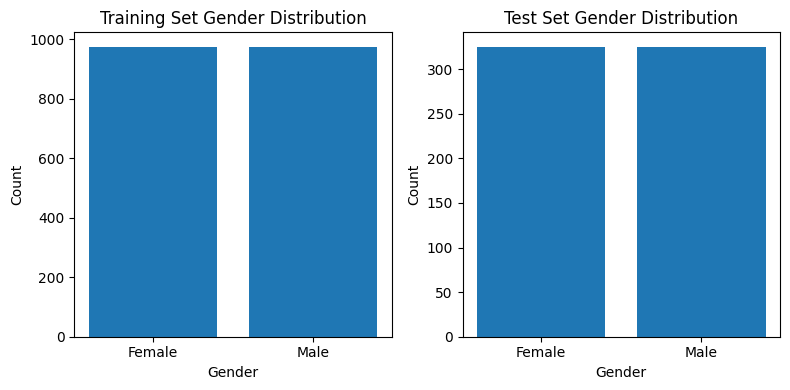

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].bar([0, 1], np.bincount(y_train_gender), tick_label=['Female', 'Male'])
axes[0].set_title("Training Set Gender Distribution")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Gender")

axes[1].bar([0, 1], np.bincount(y_test_gender), tick_label=['Female', 'Male'])
axes[1].set_title("Test Set Gender Distribution")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Gender")

plt.tight_layout()
plt.show()

## Normalization

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_gender)
X_test_scaled = scaler.transform(X_test_gender)

# Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.utils import shuffle

## Logistic Regression

In [ ]:
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nLogistic Regression Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## KNN

In [ ]:
def knn(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nKNN Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nKNN Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## SVM

In [ ]:
def svm(X_train, X_test, y_train, y_test):
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nSVM Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nSVM Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, 64)
        self.layer2 = torch.nn.Linear(64, 32)
        self.layer3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

In [ ]:
def train_mlp(X_train, X_test, y_train, y_test, epochs=100, batch_size=16):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    model = MLP(X_train.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_tensor).numpy()

    y_pred = (y_prob >= 0.5).astype(int)

    print("\nMLP Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nMLP Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return model

## ROC curve

In [ ]:
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            y_prob = model(X_test_tensor).detach().numpy().flatten()

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Different Models')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
def train_all_models(X_train, X_test, y_train, y_test):
    models = {}

    # Logistic Regression
    models["Logistic Regression"] = logistic_regression(X_train, X_test, y_train, y_test)

    # KNN
    models["KNN"] = knn(X_train, X_test, y_train, y_test)

    # SVM
    models["SVM"] = svm(X_train, X_test, y_train, y_test)

    # MLP
    models["MLP"] = train_mlp(X_train, X_test, y_train, y_test)

    # ROC curves
    plot_roc_curve(models, X_test, y_test)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       325
           1       1.00      0.98      0.99       325

    accuracy                           0.99       650
   macro avg       0.99      0.99      0.99       650
weighted avg       0.99      0.99      0.99       650


Logistic Regression Confusion Matrix:
[[324   1]
 [  5 320]]

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       325
           1       0.80      0.97      0.88       325

    accuracy                           0.86       650
   macro avg       0.88      0.86      0.86       650
weighted avg       0.88      0.86      0.86       650


KNN Confusion Matrix:
[[244  81]
 [  9 316]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       325
           1       0.99      

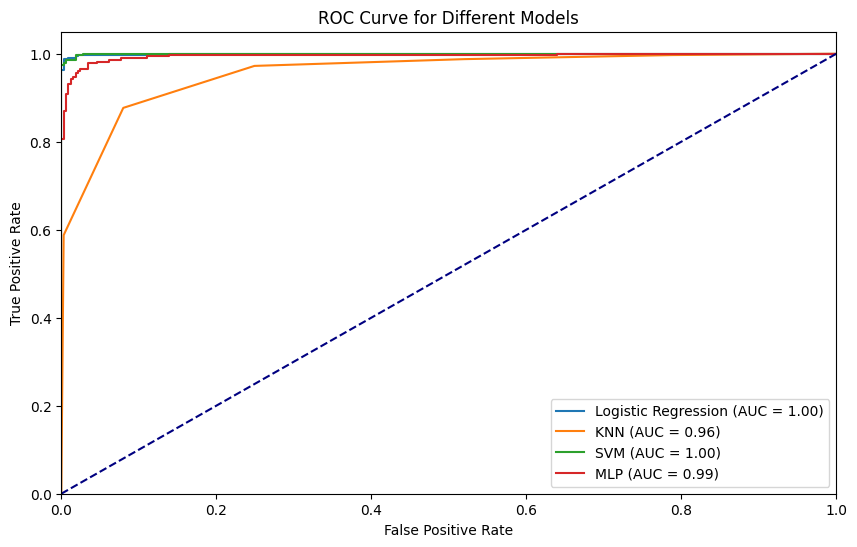

In [ ]:
train_all_models(X_train_scaled, X_test_scaled, y_train_gender, y_test_gender)

# closed-set authentication

In [ ]:
np.sort(data['ID'].value_counts())

array([  1,   1,   1,   1,   1,   7,   8,   9,  11,  12,  12,  12,  15,
        15,  15,  17,  19,  19,  21,  21,  22,  24,  25,  26,  26,  27,
        27,  28,  28,  29,  30,  30,  32,  32,  32,  33,  33,  33,  33,
        35,  35,  38,  38,  38,  39,  39,  39,  40,  40,  40,  41,  44,
        44,  45,  45,  46,  46,  47,  49,  49,  51,  52,  52,  52,  53,
        53,  54,  55,  55,  56,  56,  57,  58,  61,  62,  62,  62,  63,
        64,  65,  66,  67,  69,  69,  69,  70,  70,  72,  72,  73,  73,
        73,  75,  79,  79,  81,  83,  83,  85,  87,  91,  92, 101, 103,
       107, 111, 124, 154, 155, 164, 216, 222, 224], dtype=int64)

We take 10 students (5 male and 5 female) for this task if they have at least 50 samples.

In [ ]:
def get_data(data):

    id_counts = data['ID'].value_counts()
    valid_ids = id_counts[id_counts > 50].index
    good_data = data[data['ID'].isin(valid_ids)]

    male_ids = good_data[good_data['Gender'] == 1]['ID'].unique()
    female_ids = good_data[good_data['Gender'] == 0]['ID'].unique()

    selected_male = np.random.choice(male_ids, size=5, replace=False)
    selected_female = np.random.choice(female_ids, size=5, replace=False)

    selected_students = np.concatenate((selected_male, selected_female))
    print("Selected students are:", selected_students)

    data_filtered = data[data["ID"].isin(selected_students)]

    samples = []
    num = min(data_filtered['ID'].value_counts())

    for student in data_filtered['ID'].unique():
        samples.append(data_filtered[data_filtered['ID'] == student].sample(n=num, replace=False, random_state=343))

    data_final = pd.concat(samples)
    data_final['ID'] = data_final['ID'].astype('category')

    data_final = pd.get_dummies(data_final)

    X = data_final.drop(['Gender'], axis=1).values
    y = data_final.iloc[:, -10:].values
    y = np.argmax(y, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

Converts one-hot labels to single-class labels for sklearn models.

## Logistic Regression

In [ ]:
def logistic_regression_cls(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nLogistic Regression Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## KNN

In [ ]:
def knn_cls(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nKNN Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nKNN Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## SVM

In [ ]:
def svm_cls(X_train, X_test, y_train, y_test):
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\nSVM Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nSVM Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

## MLP

In [ ]:
class MLP_cls(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_cls, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return self.softmax(x)

In [ ]:
def train_mlp_cls(X_train, X_test, y_train, y_test, epochs=100, batch_size=16):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    model = MLP_cls(X_train.shape[1], y_train.shape[1])
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_tensor).numpy()

    y_pred = np.argmax(y_prob, axis=1)

    print("\nMLP Classification Report:")
    print(classification_report(y_test.argmax(axis=1), y_pred))
    print("\nMLP Confusion Matrix:")
    print(confusion_matrix(y_test.argmax(axis=1), y_pred))

    return model

In [ ]:
def train_all_models(data):

    X_train, X_test, y_train, y_test = get_data(data)

    models = {}

    # Logistic Regression
    models["Logistic Regression"] = logistic_regression_cls(X_train, X_test, y_train, y_test)

    # KNN
    models["KNN"] = knn_cls(X_train, X_test, y_train, y_test)

    # SVM
    models["SVM"] = svm_cls(X_train, X_test, y_train, y_test)

    y_train = np.eye(np.max(y_train) + 1)[y_train]
    y_test = np.eye(np.max(y_test) + 1)[y_test]

    # MLP
    models["MLP"] = train_mlp_cls(X_train, X_test, y_train, y_test)

In [ ]:
for i in range(3):
    train_all_models(data)

Selected students are: [810103295 810101413 810100091 810199417 810103106 810199489 810199570
 810100135 810100168 810101456]

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        13
           9       1.00      1.00      1.00        13

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133


Logistic Regression Confusion Matrix:
[[13  0  0  0  0  0  0  0  0  0]